# Calculate the Moon orbit(s) of Apollo 8

### Aaron Geller, Dec 2018

In [1]:
import pandas as pd
from astropy import units, constants
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import csv

%matplotlib notebook

#https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
moonMass = 0.07346 *10**24 *units.kg 
moonRadius = 1736.0 *units.km

#launch time December 21, 1968, 12:51:00 UTC
#wikipedia: Earthrise time December 24, 1968, 16:00 UTC (according to wikipedia; 03d 03h 49m after launch)
#51m+49m = 1h 40m
#12h + 3h = 15h
#15h 40m
#this implies Dec. 24, 15:40:00 UTC
#
#from this website: http://100photos.time.com/photos/nasa-earthrise-apollo-8
#It was on December 24, 1968, exactly 75 hours, 48 minutes and 41 seconds
#
#and according to this website http://www.collectspace.com/ubb/Forum29/HTML/001831.html
#Earthrise image was taken at 075:48:39 MET. (Credit: NASA Goddard LRO); MET == mission elapsed time
tER = (75. + 48./60. + 39./3600.) * units.hr


### Read in the File.

*See description within that file at the top.  Values come from [this document](/www.hq.nasa.gov/alsj/a410/A08_MissionReport.pdf), page 50 (5-7), Table 5-II.*

In [2]:
df = pd.read_csv('TrajectoryParameters.csv', comment='#', header=0)
df

,Event,Ref.body,time,latitude(deg),longitude(deg),altitude(nmi),velocity(ft/sec),flight-path_angle(deg),heading_angle(degEofN)
0,1,2,3,4,5,6.0,7.0,8.00,9.00
1,S-IC center engine cutoff,Earth,0:02:05.9,28.72N,80.19W,22.4,NaN,NaN,NaN
2,S-IC outboard engine cutoff,Earth,0:02:33.8,28.85N,79.73W,35.5,NaN,NaN,NaN
3,S-II engine cutoff,Earth,0:08:44.0,31.72N,65.39W,103.4,NaN,NaN,NaN
4,S-IVB engine cutoff,Earth,0:11:25.0,32.63N,54.06W,103.3,NaN,NaN,NaN
5,Parking orbit insertion,Earth,0:11:35.0,32.65N,53.20W,103.3,NaN,NaN,NaN
6,S-IVB restart preparation,Earth,2:40:59.5,11.67S,162.41E,105.3,NaN,NaN,NaN
7,S-IVB ignition,Earth,2:50:37.1,9.25N,166.55W,106.4,NaN,NaN,NaN
8,S-IVB cutoff,Earth,2:55:55.5,21.12N,144.79W,179.3,NaN,NaN,NaN
9,Translunar injection,Earth,2:56:05.5,21.48N,143.02W,187.1,NaN,NaN,NaN


*Select the Lunar Orbit*

In [3]:
lunar = [15, 16, 17, 18]
moonOrbit = df.iloc[lunar].reset_index(drop=True)
moonOrbit

,Event,Ref.body,time,latitude(deg),longitude(deg),altitude(nmi),velocity(ft/sec),flight-path_angle(deg),heading_angle(degEofN)
0,Lunar orbit insertion Ignition,Moon,69:08:20.4,7.46S,163.98W,76.6,8391.0,-6.43,-123.79
1,Lunar orbit insertion Cutoff,Moon,69:12:27.3,9.89S,179.56E,62.0,5458.0,-0.79,-117.13
2,Lunar orbit circularization Ignition,Moon,73:35:07,11.61S,160.29E,59.3,5479.0,-0.03,-110.18
3,Lunar orbit circularization Cutoff,Moon,73:35:16,11.66S,159.79E,60.7,5345.0,-0.02,-110.18


### Convert values to usable quantities with units attached.

In [4]:
update = {'latitude(deg)':[], 'longitude(deg)':[], 'altitude(nmi)':[],'velocity(ft/sec)':[], \
          'flight-path_angle(deg)':[], 'heading_angle(degEofN)':[], 'time':[]}
for index, row in moonOrbit.iterrows():
    #latitude
    pos = row['latitude(deg)'][-1]
    d = 1.
    if (pos == 'S'): d = -1.
    update['latitude(deg)'].append(d*float(row['latitude(deg)'][0:-1]) * units.degree)
    
    #longitude
    pos = row['longitude(deg)'][-1]
    if (pos == 'E'): 
        update['longitude(deg)'].append(float(row['longitude(deg)'][0:-1]) * units.degree)    
    else:
        update['longitude(deg)'].append((360. - float(row['longitude(deg)'][0:-1])) * units.degree)    

    #alititude
    update['altitude(nmi)'].append(float(row['altitude(nmi)']) * units.imperial.nauticalmile)

    #velocity
    update['velocity(ft/sec)'].append(float(row['velocity(ft/sec)']) * units.imperial.ft/units.s)

    #angles
    update['flight-path_angle(deg)'].append(float(row['flight-path_angle(deg)']) * units.degree)
    update['heading_angle(degEofN)'].append(float(row['heading_angle(degEofN)']) * units.degree)
    
    #time
    t = row['time'].split(':')
    update['time'].append( (float(t[0]) + float(t[1])/60. + float(t[2])/3600.) * units.hr)

moonOrbit.update(pd.DataFrame(update))
moonOrbit

,Event,Ref.body,time,latitude(deg),longitude(deg),altitude(nmi),velocity(ft/sec),flight-path_angle(deg),heading_angle(degEofN)
0,Lunar orbit insertion Ignition,Moon,69.13900000000001 h,-7.46 deg,196.02 deg,76.6 nmi,8391.0 ft / s,-6.43 deg,-123.79 deg
1,Lunar orbit insertion Cutoff,Moon,69.20758333333333 h,-9.89 deg,179.56 deg,62.0 nmi,5458.0 ft / s,-0.79 deg,-117.13 deg
2,Lunar orbit circularization Ignition,Moon,73.58527777777778 h,-11.61 deg,160.29 deg,59.3 nmi,5479.0 ft / s,-0.03 deg,-110.18 deg
3,Lunar orbit circularization Cutoff,Moon,73.58777777777777 h,-11.66 deg,159.79 deg,60.7 nmi,5345.0 ft / s,-0.02 deg,-110.18 deg


### Get cartesian coordinates.

*From wikipedia: The heading angle σ is the angle between north and the horizontal component of the velocity vector, which describes which direction the aircraft is moving relative to cardinal directions. The flight path angle γ is the angle between horizontal and the velocity vector, which describes whether the aircraft is climbing or descending. *

*I THINK we can treat heading_angle like a longitude and flight_path_angle like a latitude*

In [5]:
update = {'t':[],'x':[],'y':[],'z':[], 'vx':[],'vy':[],'vz':[], 'r':[], 'v':[]}
    
for index, row in moonOrbit.iterrows():
    update['t'].append(row['time'])
    r = moonRadius + row['altitude(nmi)']
    update['r'].append(r)
    update['x'].append(r*np.sin(row['latitude(deg)'])*np.cos(row['longitude(deg)']))
    update['y'].append(r*np.sin(row['latitude(deg)'])*np.sin(row['longitude(deg)']))
    update['z'].append(r*np.cos(row['latitude(deg)']))
    v = row['velocity(ft/sec)']
    #vcirc = ((constants.G*moonMass/r)**0.5).decompose()
    #v = vcirc
    update['v'].append(v)
    update['vx'].append(v*np.sin(90*units.deg - row['flight-path_angle(deg)'])*np.cos(row['heading_angle(degEofN)']))
    update['vy'].append(v*np.sin(90*units.deg - row['flight-path_angle(deg)'])*np.sin(row['heading_angle(degEofN)']))
    update['vz'].append(v*np.cos(90*units.deg - row['flight-path_angle(deg)']))

coord = pd.DataFrame(update)
coord
print(coord.iloc[3])
#print(coord['vx'].values[0])
#a check
#velocity = np.array([coord['vx'].values[0].value, coord['vy'].values[0].value, coord['vz'].values[0].value])
#print(velocity)
#print(np.linalg.norm(velocity))

r                   1848.4164 km
t            73.58777777777777 h
v                  5345.0 ft / s
vx    -1843.8676490074806 ft / s
vy     -5016.888837904891 ft / s
vz    -1.8657569324920236 ft / s
x           350.5718631703892 km
y         -129.05480444358483 km
z          1810.2727457464057 km
Name: 3, dtype: object


*Check the circular velocity*

In [6]:
i =3
vcirc = (constants.G*moonMass/coord.iloc[i]['r'])**0.5
print(vcirc.to(units.km/units.s), coord.iloc[i]['v'].to(units.km/units.s), coord.iloc[i]['r'])

1.628625609008417 km / s 1.6291560000000003 km / s 1848.4164 km


### Attempt to derive the orbit

*The function below is converted from AMUSE*

In [7]:
def orbital_elements_from_binary(m1, m2, coord1, coord2, lunit=units.km, tunit=units.s, munit=units.solMass):
    G = constants.G
    
    mass1 = m1.to(munit)
    mass2 = m2.to(munit)
    total_mass = mass1 + mass2
    
    velocity = np.array([coord1['vx'].to(lunit/tunit).value - coord2['vx'].to(lunit/tunit).value, \
                         coord1['vy'].to(lunit/tunit).value - coord2['vy'].to(lunit/tunit).value, \
                         coord1['vz'].to(lunit/tunit).value - coord2['vz'].to(lunit/tunit).value]) * lunit/tunit
    position = np.array([coord1['x'].to(lunit).value - coord2['x'].to(lunit).value, \
                         coord1['y'].to(lunit).value - coord2['y'].to(lunit).value, \
                         coord1['z'].to(lunit).value - coord2['z'].to(lunit).value]) * lunit
    v2 = np.linalg.norm(velocity)**2. * (lunit/tunit)**2.
    r = np.linalg.norm(position) * lunit
    
    specific_energy = 0.5*v2 - G*total_mass/r
    specific_angular_momentum = np.cross(position, velocity) * lunit**2./tunit
    specific_angular_momentum_norm = np.linalg.norm(specific_angular_momentum) * lunit**2./tunit
    specific_angular_momentum_unit = specific_angular_momentum/specific_angular_momentum_norm

    semimajor_axis = -G*total_mass/(2.0*specific_energy)
        
    eccentricity_argument = 2.0*specific_angular_momentum_norm**2*specific_energy/(G**2*total_mass**2)
    if (eccentricity_argument <= -1): 
        eccentricity = 0.0
    else: 
        eccentricity = np.sqrt(1.0 + eccentricity_argument)
                
        
    ### Orbital inclination ###
    inclination = np.degrees(np.arccos(specific_angular_momentum[2]/specific_angular_momentum_norm))

    ### Longitude of ascending nodes, with reference direction along x-axis ###
    z_vector = [0.,0.,1.] 
    ascending_node_vector = np.cross(z_vector, specific_angular_momentum)
    if np.linalg.norm(ascending_node_vector)==0:
        ascending_node_vector_unit= np.array([1.,0.,0.]) 
    else:
        ascending_node_vector_unit = ascending_node_vector/np.linalg.norm(ascending_node_vector)
    long_asc_node = np.degrees(np.arctan2(ascending_node_vector_unit[1],ascending_node_vector_unit[0]))

    ### Argument of periapsis and true anomaly, using eccentricity a.k.a. Laplace-Runge-Lenz vector ###
    mu = G*total_mass ### Argument of pericenter ###
    position_unit = (position/np.linalg.norm(position)).value #is this OK, even if we use different units?
    cunit = lunit/tunit*lunit**2./tunit #velocity unit * specific angular momentum unit
    e_vector = ( (1.0/mu)*np.cross(velocity,specific_angular_momentum)*cunit - position_unit )
    if (np.linalg.norm(e_vector) == 0.0): ### Argument of pericenter and true anomaly cannot be determined for e = 0, in this case return 1.0 for the cosines ###
        cos_arg_per = 1.0
        arg_per=0.
        cos_true_anomaly = 1.0
        true_anomaly=0.
    else:
        e_vector_unit = e_vector/np.linalg.norm(e_vector)
        
        cos_arg_per = np.dot(e_vector_unit, ascending_node_vector_unit)
        e_cross_an = np.cross(e_vector_unit, ascending_node_vector_unit)
        ss = -np.sign(np.dot(specific_angular_momentum_unit, e_cross_an))
        sin_arg_per = ss*(e_cross_an**2).sum()**0.5
        arg_per = np.degrees(np.arctan2(sin_arg_per, cos_arg_per))

        cos_true_anomaly = np.dot(e_vector_unit, position_unit)
        e_cross_pos = np.cross(e_vector_unit, position_unit)
        ss = np.sign(np.dot(specific_angular_momentum_unit, e_cross_pos))
        sin_true_anomaly = ss*(e_cross_pos**2).sum()**0.5
        true_anomaly = np.degrees(np.arctan2(sin_true_anomaly, cos_true_anomaly))

        
    return {"m1":mass1, 
            "m2":mass2, 
            "a":semimajor_axis.decompose().to(lunit), 
            "e":eccentricity.decompose().value, 
            "ta":true_anomaly*units.degree, 
            "inc":inclination, 
            "lan":long_asc_node*units.degree, 
            "ap":arg_per*units.degree}


In [21]:
def createOrbit(orbit, tperi, tnow, tend=None, Ntimes = 10.):

    #calculate the period
    period = (((4.*np.pi**2./(constants.G*(orbit['m1'] + orbit['m2'])))*orbit['a']**3.)**0.5).decompose().to(units.hr)

    if (tend == None):
        tend = tnow + period
    times = np.linspace(tnow, tend, Ntimes)
    print(tnow, tend, (tend-tnow)/period, period)
    
    b = np.array([-1.*orbit['inc'].to(units.radian).value, 
                  orbit['lan'].to(units.radian).value, 
                  orbit['ap'].to(units.radian).value])
    c = np.cos(b)
    s = np.sin(b)

    P = []
    P.append(-1.*c[2]*c[1] + s[2]*c[0]*s[1])
    P.append(-1.*c[2]*s[1] - s[2]*c[0]*c[1])
    P.append(-1.*s[2]*s[0])
    Q = []
    Q.append(s[2]*c[1] + c[2]*c[0]*s[1])
    Q.append(s[2]*s[1] - c[2]*c[0]*c[1])
    Q.append(-1.*s[0]*c[2])

    geometry = []
    for t in times:

        tdiff = t - tperi
        phase = (tdiff % period)/period
        E = (2.*np.pi*phase) * units.radian        
        pos = [] #x,y,z,t
        for j in range(3):
            pos.append(orbit['a']*( (np.cos(E) - orbit['e'])*P[j] +\
                       (1.0 - orbit['e']**2.)**0.5*np.sin(E)*Q[j]))
        pos.append(t)
        geometry.append(pos);

    return geometry


*Create the orbit.*

In [22]:
coord2 = {'x':0*units.km, 'y':0*units.km, 'z':0*units.km, \
          'vx':0*units.km/units.s, 'vy':0*units.km/units.s, 'vz':0*units.km/units.s}
orbit1 = orbital_elements_from_binary( moonMass, 0*units.kg, coord.iloc[1], coord2)
orbit2 = orbital_elements_from_binary( moonMass, 0*units.kg, coord.iloc[3], coord2)
print(orbit1)
print(orbit2)

{'m1': <Quantity 3.69428756e-08 solMass>, 'm2': <Quantity 0. solMass>, 'a': <Quantity 1937.56449646 km>, 'e': 0.10108519393654317, 'ta': <Quantity -69.03455112 deg>, 'inc': <Quantity 98.86328062 deg>, 'lan': <Quantity 62.99319995 deg>, 'ap': <Quantity 154.62893102 deg>}
{'m1': <Quantity 3.69428756e-08 solMass>, 'm2': <Quantity 0. solMass>, 'a': <Quantity 1849.62132055 km>, 'e': 0.0006928866128510054, 'ta': <Quantity -19.93084461 deg>, 'inc': <Quantity 101.65999799 deg>, 'lan': <Quantity 69.82412724 deg>, 'ap': <Quantity 109.93774185 deg>}


*Sample the orbit.*

In [38]:
#distance unit to use
dUnit = units.km

In [39]:
#not sure what to use for tperi...
geo1 = createOrbit(orbit1, coord.iloc[1]['t'], coord.iloc[1]['t'], tend=coord.iloc[3]['t'], Ntimes = 100.)
geo2 = createOrbit(orbit2, coord.iloc[1]['t'], coord.iloc[3]['t'], Ntimes = 100.)
t = []
x = []
y = []
z = []
lat = []
lon = []
alt = []
# for xx in geo1:
#     x.append(xx[0].to(dUnit).value)
#     y.append(xx[1].to(dUnit).value)
#     z.append(xx[2].to(dUnit).value)
#     t.append(xx[3].to(units.hour).value)
for xx in geo2:
    x.append(xx[0].to(dUnit).value)
    y.append(xx[1].to(dUnit).value)
    z.append(xx[2].to(dUnit).value)
    t.append(xx[3].to(units.hour).value)

x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
r = (x**2. + y**2. + z**2.)**0.5
lat = np.arccos(z/r)*180./np.pi
lon = np.arctan2(y,x)*180./np.pi
alt = (r*dUnit - moonRadius).to(units.km).value

69.20758333333333 h 73.58777777777777 h 2.060406619888544 2.125888357260949 h
73.58777777777777 h 75.57058474308539 h 0.9999999999999964 1.9828069653076241 h


/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


*Location of Earthrise*

In [40]:
#again, not sure what to use for tperi
geoER = createOrbit(orbit2, coord.iloc[1]['t'], tER, tend=tER, Ntimes = 1)[0]
xER = geoER[0].to(dUnit).value
yER = geoER[1].to(dUnit).value
zER = geoER[2].to(dUnit).value
rER = (xER**2. + yER**2. + zER**2.)**0.5
latER = np.arccos(zER/rER)*180./np.pi
lonER = np.arctan2(yER,xER)*180./np.pi
altER = (rER*dUnit - moonRadius).to(units.km).value

75.81083333333333 h 75.81083333333333 h 0.0 1.9828069653076241 h


*Some cardinal points*

In [47]:
latC = np.array([0, 90, 180, 270,  0, 90, 180, 270, 0,   90,  180, 270,   0,  90, 180, 270])
lonC = np.array([0,  0,   0,   0, 90, 90,  90,  90, 180, 180, 180, 180, 270, 270, 270, 270])
altC = np.full_like(latC, 0.)
r = moonRadius
xC = (r*np.sin(latC*np.pi/180.)*np.cos(lonC*np.pi/180.)).to(dUnit).value
yC = (r*np.sin(latC*np.pi/180.)*np.sin(lonC*np.pi/180.)).to(dUnit).value
zC = (r*np.cos(latC*np.pi/180.)).to(dUnit).value


*Plot the orbit*

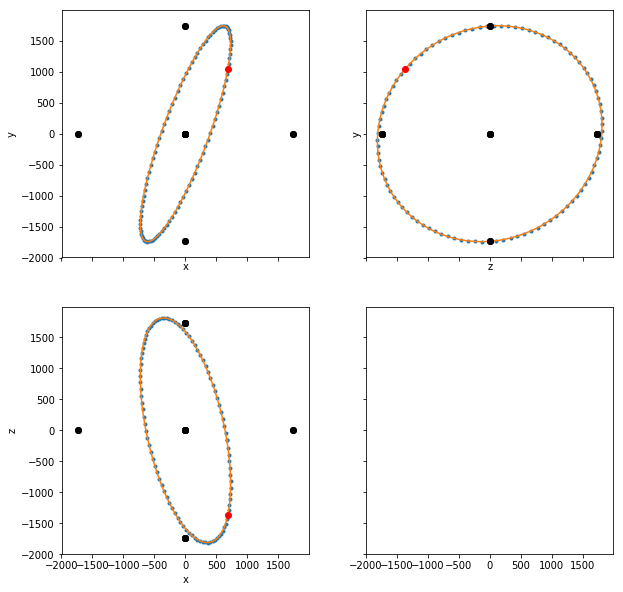

In [48]:
f,ax= plt.subplots(2,2, figsize=(10,10), sharex = True, sharey=True)
ax[0][0].plot(x,y,'.')
ax[0][0].plot(x,y)
ax[0][0].plot(xER,yER,'o', color='red')
ax[0][0].plot(xC,yC,'o', color='black')
ax[0][0].set_xlabel('x')
ax[0][0].set_ylabel('y')

ax[1][0].plot(x,z,'.')
ax[1][0].plot(x,z)
ax[1][0].plot(xER,zER,'o', color='red')
ax[1][0].plot(xC,zC,'o', color='black')
ax[1][0].set_xlabel('x')
ax[1][0].set_ylabel('z')

ax[0][1].plot(z,y,'.')
ax[0][1].plot(z,y)
ax[0][1].plot(zER,yER,'o', color='red')
ax[0][1].plot(zC,yC,'o', color='black')
ax[0][1].set_xlabel('z')
ax[0][1].set_ylabel('y')


for a in ax.flatten():
    a.set_aspect('equal')
    


### Write to file

In [49]:
csvfile = open("MoonOrbit.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
for i in range(len(x)):
    csvwriter.writerow([x[i],y[i],z[i], lat[i],lon[i],alt[i], t[i], 0., 0.])
    
csvwriter.writerow([xER,yER,zER, latER,lonER,altER, tER, 1., 0.])

for i in range(len(xC)):
    csvwriter.writerow([xC[i],yC[i],zC[i], latC[i],lonC[i],altC[i], 0, 2., 0.])
    
csvfile.close()